In [1]:
import functools

import ase
from ase.visualize import view

import jax
import jax.numpy as jnp

import flax
import flax.linen as nn
import optax
from clu import metrics

import matplotlib.pyplot as plt

from molnet.data import input_pipeline_online
from molnet.models import create_model
from molnet import train_state
from molnet import loss

from configs import attention_unet
from configs import root_dirs

from typing import Any, Dict, Tuple, Callable

2024-12-10 15:16:51.373022: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
config = attention_unet.get_config()
config.batch_size = 4
config.interpolate_input_z = None
config.z_cutoff = 1.0
config.gaussian_factor = 5.0
config.train_molecules = (0, 80000)
config.val_molecules = (80000, 100000)
#config.train_molecules = (0, 50000)
#config.val_molecules = (50000, 60000)
config.root_dir = root_dirs.get_root_dir("afms_rebias")

@flax.struct.dataclass
class Metrics(metrics.Collection):
    loss: metrics.Average.from_output("loss") # type: ignore

In [3]:
ds = input_pipeline_online.get_datasets(config)
rng = jax.random.PRNGKey(0)
init_rng, rng = jax.random.split(rng)

model = create_model(config.model)
dummy_input = next(ds['train'])
print(f"input shape: {dummy_input['images'].shape}")
print(f"atom map shape: {dummy_input['atom_map'].shape}")
variables = model.init(init_rng, dummy_input["images"], training=False)
params = variables["params"]
batch_stats = variables["batch_stats"]

loss_fn = loss.get_loss_function(config.loss_fn)
tx = optax.adam(learning_rate=3e-4)

2024-12-10 15:16:53.736817: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1960] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...
[libprotobuf ERROR external/com_google_protobuf/src/google/protobuf/text_format.cc:337] Error parsing text-format tensorflow.data.experimental.DistributedSnapshotMetadata: 1:1: Invalid control characters encountered in text.
[libprotobuf ERROR external/com_google_protobuf/src/google/protobuf/text_format.cc:337] Error parsing text-format tensorflow.data.experimental.DistributedSnapshotMetadata: 1:3: Expected identifier, got: 18085879115725111131
[libprotobuf ERROR external/com_google_protobuf/src/google/protobuf/text_format.cc:337] Error parsing text-format tensorflow.data.experimental.DistributedSna

input shape: (4, 128, 128, 10, 1)
atom map shape: (4, 128, 128, 10, 5)


In [4]:
train_metrics = Metrics.empty()

state = train_state.TrainState.create(
    apply_fn=model.apply,
    params=params,
    batch_stats=batch_stats,
    tx=tx,
    best_params=params,
    step_for_best_params=0,
    metrics_for_best_params={},
)

In [5]:
@functools.partial(jax.jit, static_argnums=(2,))
def train_step(
    state: train_state.TrainState,
    batch: Dict[str, Any],
    loss_fn: Callable[[jnp.ndarray, jnp.ndarray], jnp.ndarray]
) -> Tuple[train_state.TrainState, metrics.Collection]:
    """Train step."""

    def loss_wrapper(params):
        preds, updates = state.apply_fn(
            {'params': params, 'batch_stats': state.batch_stats},
            batch["images"][..., -10:, :],
            training=True,
            mutable='batch_stats',
        )
        total_loss = loss_fn(
            preds,
            batch["atom_map"]
        )
        #mean_loss = jnp.mean(total_loss)

        return total_loss, (preds, updates)

    # Compute loss and gradients
    grad_fn = jax.value_and_grad(loss_wrapper, has_aux=True)
    (batch_loss, (_, updates)), grads = grad_fn(state.params)

    batch_metrics = Metrics.single_from_model_output(
        loss=batch_loss,
    )

    # Update parameters
    new_state = state.apply_gradients(
        grads=grads,
        batch_stats=updates["batch_stats"]
    )

    return new_state, batch_metrics


In [6]:
@functools.partial(jax.jit)
def pred_batch(
    state: train_state.TrainState,
    batch: Dict[str, Any],
) -> jnp.ndarray:
    preds = state.apply_fn(
        {'params': state.params, 'batch_stats': state.batch_stats},
        batch["images"][..., -10:, :],
        training=False,
    )
    return preds

In [29]:
train_metrics = Metrics.empty()
for i in range(2000):
    batch = next(ds['train'])
    state, batch_metrics = train_step(state, batch, loss_fn)
    train_metrics = train_metrics.merge(batch_metrics)
    if i % 10 == 0:
        train_metrics = train_metrics.compute()
        print(f"step {i}, loss: {train_metrics}")
        train_metrics = Metrics.empty()

step 0, loss: {'loss': Array(0.00140257, dtype=float32)}
step 10, loss: {'loss': Array(0.00280975, dtype=float32)}
step 20, loss: {'loss': Array(0.00368339, dtype=float32)}
step 30, loss: {'loss': Array(0.00375335, dtype=float32)}
step 40, loss: {'loss': Array(0.00337731, dtype=float32)}
step 50, loss: {'loss': Array(0.00342233, dtype=float32)}
step 60, loss: {'loss': Array(0.00271711, dtype=float32)}
step 70, loss: {'loss': Array(0.00318888, dtype=float32)}
step 80, loss: {'loss': Array(0.00431291, dtype=float32)}
step 90, loss: {'loss': Array(0.00334419, dtype=float32)}
step 100, loss: {'loss': Array(0.00349515, dtype=float32)}
step 110, loss: {'loss': Array(0.00390078, dtype=float32)}
step 120, loss: {'loss': Array(0.00369114, dtype=float32)}
step 130, loss: {'loss': Array(0.00359789, dtype=float32)}
step 140, loss: {'loss': Array(0.00308987, dtype=float32)}
step 150, loss: {'loss': Array(0.00356318, dtype=float32)}
step 160, loss: {'loss': Array(0.00369908, dtype=float32)}
step 170

[libprotobuf ERROR external/com_google_protobuf/src/google/protobuf/text_format.cc:337] Error parsing text-format tensorflow.data.experimental.DistributedSnapshotMetadata: 1:1: Invalid control characters encountered in text.
[libprotobuf ERROR external/com_google_protobuf/src/google/protobuf/text_format.cc:337] Error parsing text-format tensorflow.data.experimental.DistributedSnapshotMetadata: 1:3: Expected identifier, got: 13792930617297007781
[libprotobuf ERROR external/com_google_protobuf/src/google/protobuf/text_format.cc:337] Error parsing text-format tensorflow.data.experimental.DistributedSnapshotMetadata: 1:1: Invalid control characters encountered in text.
[libprotobuf ERROR external/com_google_protobuf/src/google/protobuf/text_format.cc:337] Error parsing text-format tensorflow.data.experimental.DistributedSnapshotMetadata: 1:3: Expected identifier, got: 16996739089512361647
[libprotobuf ERROR external/com_google_protobuf/src/google/protobuf/text_format.cc:337] Error parsing 

step 350, loss: {'loss': Array(0.00313083, dtype=float32)}
step 360, loss: {'loss': Array(0.00433213, dtype=float32)}
step 370, loss: {'loss': Array(0.00380116, dtype=float32)}
step 380, loss: {'loss': Array(0.00310516, dtype=float32)}
step 390, loss: {'loss': Array(0.00353794, dtype=float32)}
step 400, loss: {'loss': Array(0.00315711, dtype=float32)}
step 410, loss: {'loss': Array(0.0041015, dtype=float32)}
step 420, loss: {'loss': Array(0.00253497, dtype=float32)}
step 430, loss: {'loss': Array(0.00508105, dtype=float32)}
step 440, loss: {'loss': Array(0.00386943, dtype=float32)}
step 450, loss: {'loss': Array(0.00329944, dtype=float32)}
step 460, loss: {'loss': Array(0.00391393, dtype=float32)}
step 470, loss: {'loss': Array(0.00393247, dtype=float32)}
step 480, loss: {'loss': Array(0.0033439, dtype=float32)}
step 490, loss: {'loss': Array(0.00332071, dtype=float32)}
step 500, loss: {'loss': Array(0.00369675, dtype=float32)}
step 510, loss: {'loss': Array(0.00297747, dtype=float32)}

[libprotobuf ERROR external/com_google_protobuf/src/google/protobuf/text_format.cc:337] Error parsing text-format tensorflow.data.experimental.DistributedSnapshotMetadata: 1:1: Invalid control characters encountered in text.
[libprotobuf ERROR external/com_google_protobuf/src/google/protobuf/text_format.cc:337] Error parsing text-format tensorflow.data.experimental.DistributedSnapshotMetadata: 1:3: Expected identifier, got: 5241819732964010544
[libprotobuf ERROR external/com_google_protobuf/src/google/protobuf/text_format.cc:337] Error parsing text-format tensorflow.data.experimental.DistributedSnapshotMetadata: 1:1: Invalid control characters encountered in text.
[libprotobuf ERROR external/com_google_protobuf/src/google/protobuf/text_format.cc:337] Error parsing text-format tensorflow.data.experimental.DistributedSnapshotMetadata: 1:3: Expected identifier, got: 6803948576376226594
[libprotobuf ERROR external/com_google_protobuf/src/google/protobuf/text_format.cc:337] Error parsing te

step 1880, loss: {'loss': Array(0.00273255, dtype=float32)}
step 1890, loss: {'loss': Array(0.00281709, dtype=float32)}
step 1900, loss: {'loss': Array(0.00236896, dtype=float32)}
step 1910, loss: {'loss': Array(0.00289813, dtype=float32)}
step 1920, loss: {'loss': Array(0.00320682, dtype=float32)}
step 1930, loss: {'loss': Array(0.00313752, dtype=float32)}
step 1940, loss: {'loss': Array(0.00333351, dtype=float32)}
step 1950, loss: {'loss': Array(0.00271199, dtype=float32)}
step 1960, loss: {'loss': Array(0.00297017, dtype=float32)}
step 1970, loss: {'loss': Array(0.00362382, dtype=float32)}
step 1980, loss: {'loss': Array(0.00276213, dtype=float32)}
step 1990, loss: {'loss': Array(0.0025848, dtype=float32)}


In [30]:
batch = next(ds['val'])
y = pred_batch(state, batch)
idx = 1
y0 = y[idx]
ref = batch["atom_map"][idx]
print(f"ref min/max: {ref.min()}, {ref.max()}")
x0 = batch["images"][idx]

ref min/max: 0.0, 4.990433692932129


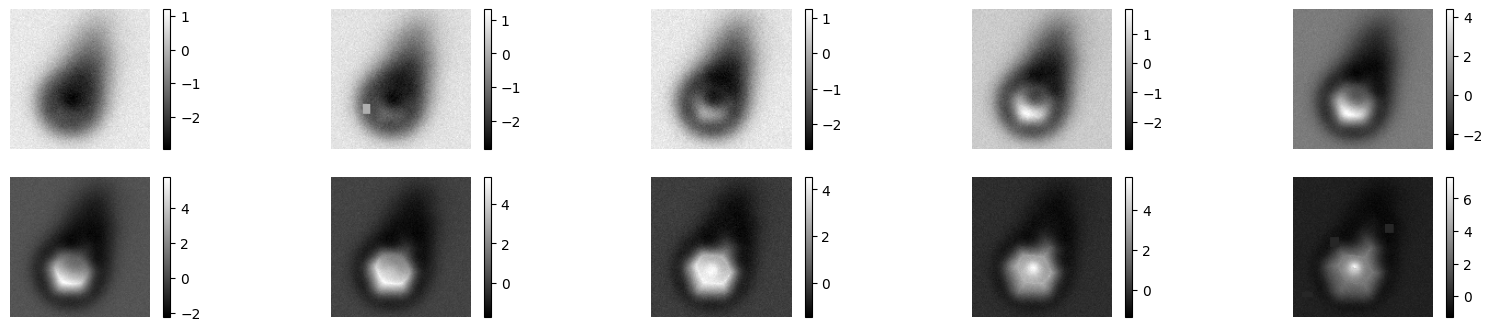

In [31]:
fig = plt.figure(figsize=(20, 4))
for i in range(10):
    ax = plt.subplot(2, 5, i+1)
    im = ax.imshow(x0[..., i, 0], cmap='gray', origin='lower')
    plt.colorbar(im)

    ax.axis('off')


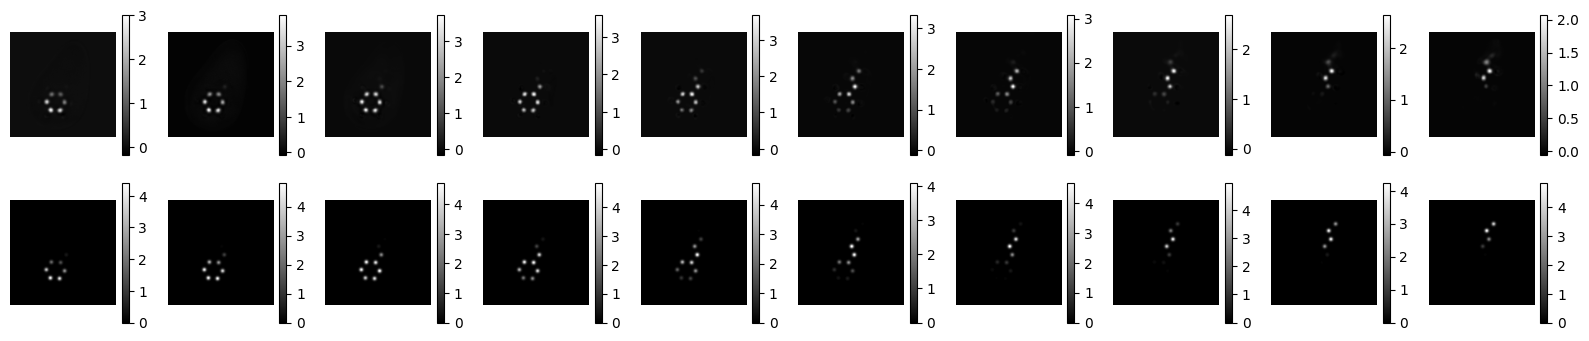

In [32]:
channel = 1

fig = plt.figure(figsize=(20, 4))
for i in range(10):
    ax = plt.subplot(2, 10, i+1)
    im = ax.imshow(y0[..., i, channel], cmap='gray', origin='lower',)
    plt.colorbar(im)
    ax.axis('off')

    ax = plt.subplot(2, 10, i+11)
    im = ax.imshow(ref[..., i, channel], cmap='gray', origin='lower')
    plt.colorbar(im)
    ax.axis('off')



In [14]:
xyz = batch["xyz"][idx]
mol = ase.Atoms(positions=xyz[:, :3], numbers=xyz[:, -1])
view(mol)

<Popen: returncode: None args: ['/u/79/kurkil1/unix/.venvs/tf-2.13/bin/pytho...>